In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [ ]:
# import data
prices_df = pd.read_csv('https://eco-prices-scrapes.s3.eu-west-2.amazonaws.com/teaching/redacted_prices_df.csv')
items_df = pd.read_csv('https://eco-prices-scrapes.s3.eu-west-2.amazonaws.com/teaching/redacted_items_df.csv')


In [108]:
# merge data
df = pd.merge(prices_df, items_df, on=['store_id', 'product_id'], how='inner')
df

,date,price,unit_price,loyalty_price,original_price,store_id,product_id,cpi_id,cpi_name
0,2023-10-06,12.95,0.16 per 100ml,NaN,NaN,5,209870.0,212023.0,cola/fizzy drink 330ml pk 4-8
1,2023-10-06,12.95,0.16 per 100ml,NaN,NaN,5,209870.0,212025.0,"cola drink, reg,bottle,1.25-2l"
2,2023-10-06,9.00,9 per 75cl,NaN,NaN,5,265800.0,310426.0,sparkling wine 75cl min 11%abv
3,2023-10-06,4.00,1.29 per 100g,NaN,NaN,5,181052.0,212228.0,malted chocolate sweets
4,2023-10-06,4.00,1.29 per 100g,NaN,NaN,5,181052.0,212218.0,carton/box of chocs 150-400gm
...,...,...,...,...,...,...,...,...,...
6443978,2024-05-06,2.75,£4.44 per 1 litre,NaN,NaN,7,163496.0,310220.0,spec'y beer bott 500ml 4-5.5
6443979,2024-05-06,2.75,£4.44 per 1 litre,NaN,NaN,7,163496.0,310111.0,bottled premium lager 4.3-7.5%
6443980,2024-05-06,2.75,£4.44 per 1 litre,NaN,NaN,7,163496.0,310217.0,lager 10-24 bottles 250-330ml
6443981,2024-04-08,10.00,£2.53/lt,NaN,NaN,1,62053.0,310215.0,lager 4 bottles- premium


In [91]:
## graph 1, price density by store, last date 

# Calculate the last observation per store_id and product_id 
last_observation_df = df.drop_duplicates(subset=['store_id', 'product_id'], keep='last')
last_observation_df['store_id'] = "Store " + last_observation_df['store_id'].astype(str)  # Adding 'Store' to store_id for nicer labels

# clean percentile
percentiles = last_observation_df.groupby('store_id')['price'].quantile([0.25, 0.75]).unstack()

# Filter the data to remove outliers outside the 2.5th and 97.5th percentiles
filtered_df = last_observation_df[
    last_observation_df.apply(
        lambda row: (percentiles.loc[row['store_id'], 0.25] <= row['price'] <= percentiles.loc[row['store_id'], 0.75]),
        axis=1
    )
]

filtered_df = filtered_df[['price', 'store_id']]

filtered_df_json = filtered_df.to_json(orient='records')


/var/folders/7b/vjmsjgqx12j148x13wgz79cr0000gn/T/ipykernel_10058/1012209345.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_observation_df['store_id'] = "Store " + last_observation_df['store_id'].astype(str)  # Adding 'Store' to store_id for nicer labels


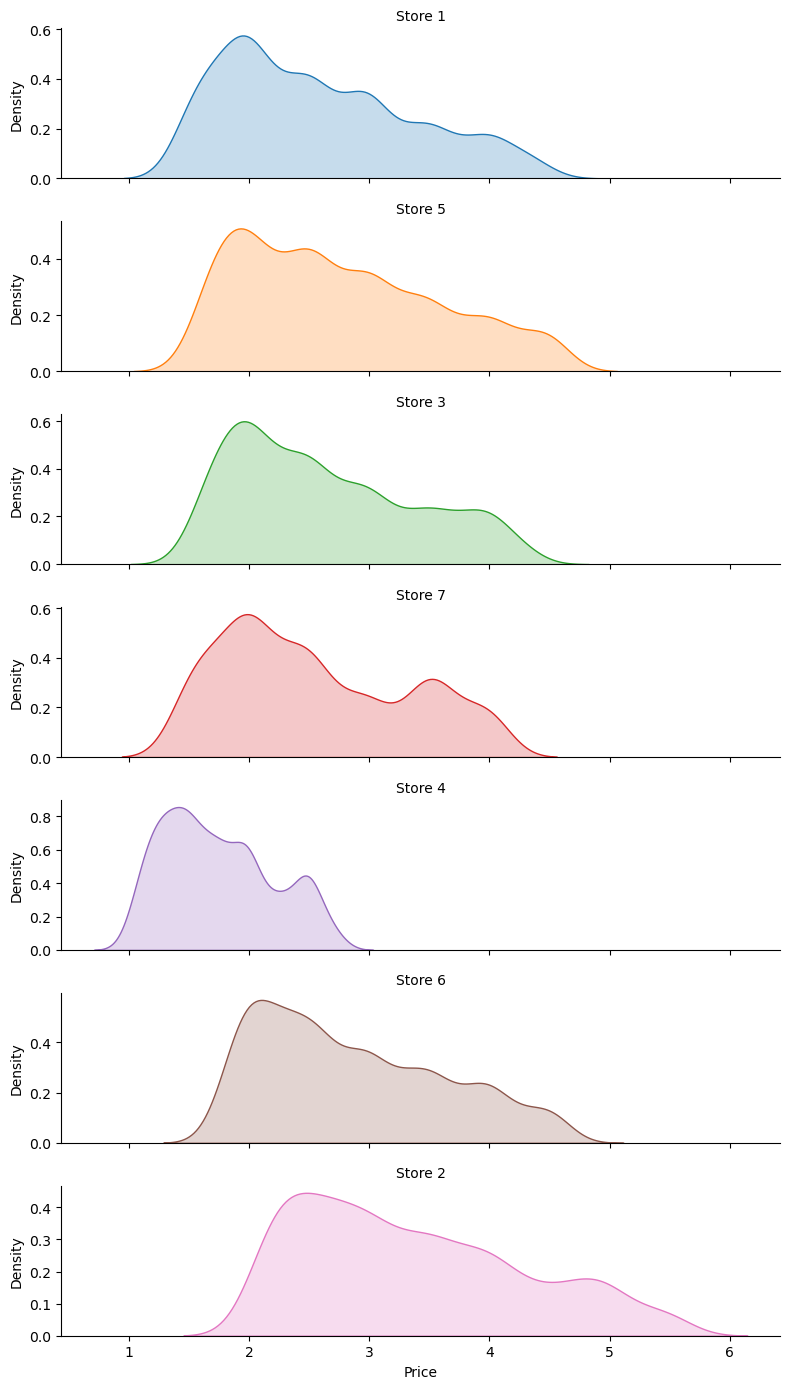

In [92]:
# test grpah 1
g = sns.FacetGrid(filtered_df, row='store_id', hue='store_id', aspect=4, height=2, sharex=True, sharey=False)

# Plot the density plot for each store_id
g.map(sns.kdeplot, 'price', fill=True)

# Customize the plot
g.set_axis_labels("Price", "Density")
g.set_titles('{row_name}')

# Show the plot
plt.show()

In [57]:
# vega lite graph 1 

import json
filtered_df_json = filtered_df.to_dict(orient='records')

vega_lite_spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "title": "Density Plot of Prices for Each Store", 
  "width": 400,
  "height": 80,
  "data": {
    "values": filtered_df_json
  },
  "mark": "area",
  "transform": [
    {
      "density": "price",
      "groupby": ["store_id"],
      "extent": [0, 6]
    }
  ],
  "encoding": {
    "x": {"field": "value", "type": "quantitative", "title": "Price"},
    "y": {"field": "density", "type": "quantitative", "stack": "zero"},
    "row": {"field": "store_id", "type": "nominal", "title": "Store"},
    "color": {"field": "store_id", "type": "nominal", "title": "Store"}
  }
}


# Save the Vega-Lite JSON specification to a file
with open('chart_8-1.json', 'w') as f:
    json.dump(vega_lite_spec, f, indent=2)

In [93]:
columns = df.columns
print(columns)

Index(['date', 'price', 'unit_price', 'loyalty_price', 'original_price',
       'store_id', 'product_id', 'cpi_id', 'cpi_name'],
      dtype='object')


/var/folders/7b/vjmsjgqx12j148x13wgz79cr0000gn/T/ipykernel_10058/4155825792.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_mean_df = monthly_mean_df.groupby('store_id').resample('M')['price'].mean().reset_index()


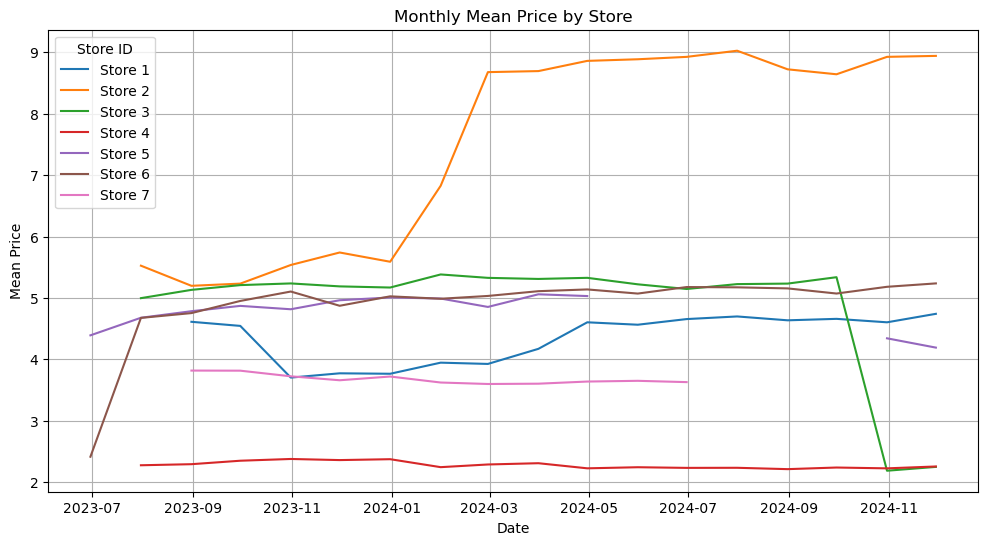

In [ ]:
## graph 2 - time series of prices by store

# Convert the date column to datetime format if not already done
monthly_mean_df = df.copy()
monthly_mean_df['date'] = pd.to_datetime(monthly_mean_df['date'])

# Set the date as the index
monthly_mean_df.set_index('date', inplace=True)

# Group by store_id and resample by month to calculate the monthly mean of price
monthly_mean_df = monthly_mean_df.groupby('store_id').resample('M')['price'].mean().reset_index()

# plot testing 
plt.figure(figsize=(12,6))
for store_id in monthly_mean_df['store_id'].unique():
    store_data = monthly_mean_df[monthly_mean_df['store_id'] == store_id]
    plt.plot(store_data['date'], store_data['price'], label=f'Store {store_id}')

plt.title('Monthly Mean Price by Store')
plt.xlabel('Date')
plt.ylabel('Mean Price')
plt.legend(title='Store ID')
plt.grid(True)
plt.show()

In [128]:
# Select only the variables needed for the graph
monthly_mean_df['date'] = monthly_mean_df['date'].dt.strftime('%Y-%m')
monthly_mean_df = monthly_mean_df.dropna()

graph_df = monthly_mean_df[['date', 'price', 'store_id']]
graph_df_json = graph_df.to_dict(orient='records')

In [131]:
import json 

vega_lite_spec_time_series = {
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Monthly Mean Price by Store",
    "width": 600,
    "height": 400,
    "data": {
        "values": graph_df_json
    },
    "transform": [
    {
      "impute": "price",
      "key": "date",
      "groupby": ["store_id"],
      "method": "value",
      "value": "null"
    }
  ],
  "mark": "line",
  "encoding": {
    "x": {"field": "date", "type": "temporal", "title": "Date"},
    "y": {"field": "price", "type": "quantitative", "title": "Mean Price"},
    "color": {"field": "store_id", "type": "nominal", "title": "Store ID"}
  }
}
# Save the Vega-Lite JSON specification to a file
with open('chart_8-2.json', 'w') as f:
        json.dump(vega_lite_spec_time_series, f, indent=2)